# Suche nach passenden Zipf / Luhn Parameter 

Um festzustellen, wie viele Wörter duch die Zipf/Luhn Analyse später für jeden Text mindestens bestimmt werden sollen, werden zunächst die folgenden Parameter über alle Texte untersucht:
- Längster Text
- Kürzester Text
- Durchschnittslänge


In [1]:
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

import plotly.express as px

In [4]:
# Datenbank-Zugangsdaten
username = 'admin'
password = 'admin'
host = 'localhost'
port = '27017'
authSource = 'admin'


# Verbindung zur MongoDB
client = MongoClient(f'mongodb://{username}:{password}@{host}:{port}/?authSource={authSource}')
db = client.web_articles
articles_collection = db.articles

## Wie lang sind die Texte in der DB?

Kürzester Text:  0
Längster Text:  6323
Durchschnittliche Anzahl der Wörter:  330.4881033310673


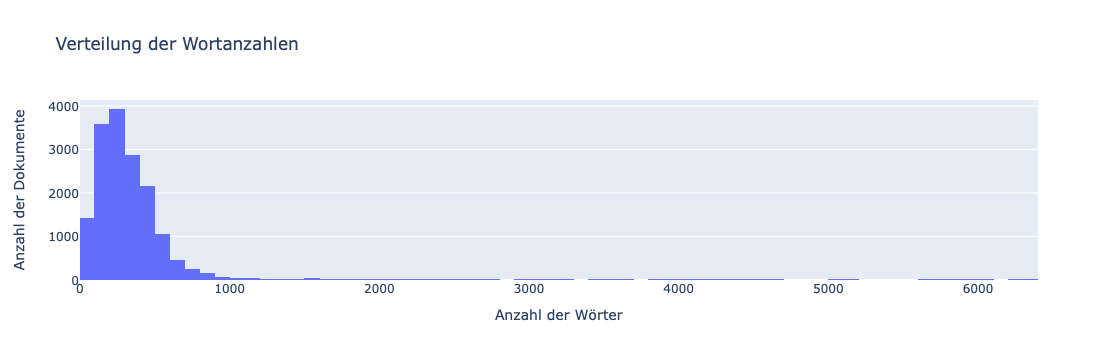

In [5]:
# Artikel aus MongoDB abrufen
articles_cursor = articles_collection.find({}, {'preprocessed_text': 1, '_id': 1})

# Listen und Variablen für Daten und Längeninformationen
texts = []
word_counts = []
ids = []
min_length = 0  # Unendlich hoch initialisieren
max_length = 0
total_length = 0
total_documents = 0
min_text = ""
max_text = ""

# Daten aus Cursor extrahieren und Längen analysieren
for article in articles_cursor:
    text = article.get('preprocessed_text', "")
    words = text.split()
    word_count = len(words)
    
    # Textdaten für den Graphen sammeln
    texts.append(text)
    word_counts.append(word_count)
    ids.append(str(article['_id']))  # Konvertiere ObjectId zu string für die Anzeige

    # Längeninformationen aktualisieren
    total_length += word_count
    total_documents += 1

    if word_count < min_length:
        min_length = word_count
        #min_text = text

    if word_count > max_length:
        max_length = word_count
        #max_text = text

# Durchschnittliche Wortanzahl berechnen
average_length = total_length / total_documents if total_documents > 0 else 0

# Ergebnisse ausgeben
print("Kürzester Text: ", min_length)
print("Längster Text: ", max_length)
print("Durchschnittliche Anzahl der Wörter: ", average_length)

# Daten in einen DataFrame umwandeln
df = pd.DataFrame({
    'Text': texts,
    'Word Count': word_counts,
    'ID': ids
})

# DataFrame nach 'Word Count' absteigend sortieren
df = df.sort_values(by='Word Count', ascending=False)
df

# Histogramm erstellen mit Plotly Express
fig = px.histogram(df, x='Word Count', nbins=100, title="Verteilung der Wortanzahlen")
fig.update_layout(xaxis_title='Anzahl der Wörter', yaxis_title='Anzahl der Dokumente')
fig.show()

## Zipf Luhn 

In [9]:
# Konfigurationseinstellungen
config = {
    'stop_words': 'english',  # Stopwörter für Englisch
    'n_keywords': 100,  # Anzahl der Schlüsselwörter, die maximal gespeichert werden sollen
    'min_df': 5,   # Minimale Dokumentfrequenz für Wörter
    'max_df': 0.8, # Maximale Dokumentfrequenz für Wörter (als Anteil)
    'bar_length': 50  # Länge des Fortschrittsbalkens
}

# Alle Artikel abrufen
articles_cursor = articles_collection.find({}, {'preprocessed_text': 1, '_id': 1})
all_texts = []
article_ids = []
word_counts = []

# Texte und IDs sammeln und Wortzählung durchführen
for article in articles_cursor:
    text = article['preprocessed_text']
    if text.strip():  # Überprüfen, ob der Text nicht leer ist
        all_texts.append(text)
        article_ids.append(article['_id'])
        word_counts.append(len(set(text.split())))  # Zählen der einzigartigen Wörter

# TF-IDF-Vectorizer initialisieren mit Häufigkeitsfiltern
vectorizer = TfidfVectorizer(stop_words=config['stop_words'], min_df=config['min_df'], max_df=config['max_df'])
tfidf_matrix = vectorizer.fit_transform(all_texts)
feature_names = np.array(vectorizer.get_feature_names_out())

# Schlüsselwörter für jeden Artikel identifizieren und speichern
for i, (article_id, word_count) in enumerate(zip(article_ids, word_counts)):
    tfidf_scores = tfidf_matrix[i, :].toarray().flatten()
    sorted_indices = np.argsort(tfidf_scores)[::-1]

    # Anpassen der Anzahl der Schlüsselwörter basierend auf der Wortanzahl
    max_keywords = min(word_count, config['n_keywords'])
    top_n_indices = sorted_indices[:max_keywords]
    top_n_words = feature_names[top_n_indices]

    articles_collection.update_one(
        {'_id': article_id},
        {'$set': {'zipf_luhn_keywords': top_n_words.tolist()}}
    )

    progress = (i + 1) / len(article_ids)
    filled_length = int(round(config['bar_length'] * progress))
    bar = '#' * filled_length + '-' * (config['bar_length'] - filled_length)
    print(f'\r[{bar}] {round(progress*100, 2)}%', end='')

print("\nFertig mit der Verarbeitung aller Artikel.")


[##################################################] 100.0%
Fertig mit der Verarbeitung aller Artikel.
